## Setup and get data

In [1]:
COMPETITION_NAME = 'digit-recognizer' # replace me

# Kaggle competition bootstrapping
!pip install -qq fastai
!pip install -qq kaggle

from fastai.imports import *
np.set_printoptions(linewidth=130)

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# get competition data
if iskaggle:
    path = Path('../input/'+COMPETITION_NAME)
else:
    DOWNLOADS = Path('downloads')
    import zipfile,kaggle
    path = DOWNLOADS / COMPETITION_NAME
    if not path.is_dir():
        kaggle.api.competition_download_cli(COMPETITION_NAME, path=DOWNLOADS)
        zipfile.ZipFile(f'{path}.zip').extractall(path)
print('done')

done


In [2]:
!ls {path}

sample_submission.csv  test  test.csv  train  train.csv


## Data preprocessing
Moving csv format to images in folders

In [3]:
df = pd.read_csv(path/'train.csv')
df.label.value_counts()

1    4684
7    4401
3    4351
9    4188
2    4177
6    4137
0    4132
4    4072
8    4063
5    3795
Name: label, dtype: int64

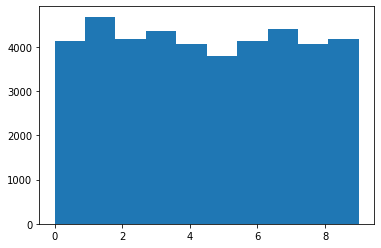

In [4]:
import matplotlib.pyplot as plt
import numpy as np
plt.hist(df.label)
plt.show()

In [5]:
test_df = pd.read_csv(path/"test.csv")
len(test_df)

28000

In [6]:
#create folders 
TRAIN_IMGS = path / 'train'
TEST_IMGS = path / 'test'
if not TRAIN_IMGS.exists():
    print('creating', TRAIN_IMGS)
    TRAIN_IMGS.mkdir()
if not TEST_IMGS.exists():
    print('creating', TEST_IMGS)
    TEST_IMGS.mkdir()
for i in range(10):
    pi = TRAIN_IMGS/(str(i))
    if not pi.exists():
        print('creating', pi)
        pi.mkdir()
print('done')

done


In [7]:
# no need to run this if it's not the first time you run this competition
from PIL import Image

def saveMNIST(digit, filepath):
    digit = digit.reshape(28,28)
    digit = digit.astype(np.uint8)

    img = Image.fromarray(digit)
    img.save(filepath)

# training set
for index, row in df.iterrows():
    label,digit = row[0], row[1:]
    folder = TRAIN_IMGS/str(label)
    filename = f"{index}.jpg"
    filepath = folder/filename
    if filepath.exists(): continue
    
    digit = digit.values
    
    saveMNIST(digit, filepath)

# test set
for index, digit in test_df.iterrows():
    filename = f"{index}.jpg"
    filepath = TEST_IMGS/filename
    if filepath.exists(): continue
    
    digit = digit.values
    
    saveMNIST(digit, filepath)


## Let's create an ensamble!

In [7]:
!pip install -q timm
!pip install -qq fastai
!pip install -qq pynvml

import timm 
from fastai.vision.all import *

files = get_image_files(TRAIN_IMGS)
len(files)

42000

## Let's first evaluate which models fit in 16GB of GPU

In [8]:
import gc
!pip install -Uqq pynvml
def free_gpu():
    gc.collect()
    torch.cuda.empty_cache()
    return 'done'
    
def report_gpu():
    print(torch.cuda.list_gpu_processes())
    free_gpu()

In [9]:
# we only use one digit to see GPU memory usage of each model 
gpu_memory_fast_train_folder = TRAIN_IMGS/'0'

def gpu_memory_fast_train(arch, size=28, accum=1, ebs=64, epochs=1):
    # effective batch size of 64, and accum=2 gives real batch_size=32
    batch_size = ebs//accum
    
    dls = ImageDataLoaders.from_folder(gpu_memory_fast_train_folder, valid_pct=0.2,
        batch_tfms=aug_transforms(size=size, min_scale=0.75), bs=batch_size)
    
    training_cbs = GradientAccumulation(ebs) if accum else []
    
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=training_cbs).to_fp16()
    learn.unfreeze()
    learn.fit_one_cycle(epochs, 0.01)

In [30]:
# convnext needs size>=32 otherwise the convolutions will reduce the data too much
gpu_memory_fast_train('convnext_small_in22k', size=32, accum=1)
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:06


GPU:0
process      22811 uses     7473.000 MB GPU memory


In [31]:
gpu_memory_fast_train('convnext_small_in22k', size=32, accum=2)
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:08


GPU:0
process      22811 uses     7839.000 MB GPU memory


In [32]:
# taken to the extreme
gpu_memory_fast_train('convnext_small_in22k', size=32, accum=16)
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:50


GPU:0
process      22811 uses     8293.000 MB GPU memory


As you can see, as accum increases, training time increases, but memory usage is reduced (in theory)

We'll now check the memory use for each of the architectures and sizes we'll be training later, to ensure they all fit in 16GB RAM. For each of these, I tried `accum=1` first, and then doubled it any time the resulting memory use was over 16GB. As it turns out, `accum=2` was what I needed for every case.

In [10]:
free_gpu()

'done'

In [11]:
gpu_memory_fast_train('convnext_large_in22k', size=32, accum=2)
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:12


GPU:0
process      31178 uses     5619.000 MB GPU memory


In [12]:
# vit requires 224 exact image size
gpu_memory_fast_train('vit_large_patch16_224', size=224, accum=2)
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,01:01


GPU:0
process      31178 uses    11829.000 MB GPU memory


In [13]:
# swinv2 requires images of exactly 192 x 192
gpu_memory_fast_train('swinv2_large_window12_192_22k', size=192, accum=2)
report_gpu()

/usr/local/lib/python3.9/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v2.0.0/swinv2_large_patch4_window12_192_22k.pth" to /root/.cache/torch/hub/checkpoints/swinv2_large_patch4_window12_192_22k.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:54


GPU:0
process      31178 uses    14025.000 MB GPU memory


In [14]:
# swin requires images of exactly 224 x 224
gpu_memory_fast_train('swin_large_patch4_window7_224', size=224, accum=2)
report_gpu()

Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window7_224_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:47


GPU:0
process      31178 uses    12475.000 MB GPU memory


In [16]:
gpu_memory_fast_train('resnet152', accum=1)
report_gpu()

epoch,train_loss,valid_loss,error_rate,time
0,0.000000,0.000000,0.000000,00:08


GPU:0
process      31178 uses     2993.000 MB GPU memory


## Running the multiple models

In [10]:
# we use full training images now
trn_path = TRAIN_IMGS 
tst_files = [TEST_IMGS/(str(i)+'.jpg') for i in range(len(test_df))]
len(tst_files)

28000

In [11]:
def train_model(arch, size, accum, ebs=64, epochs=12):
    batch_size = ebs//accum
    training_cbs = GradientAccumulation(ebs) if accum else []
    
    # create image data loaders
    dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2,
        batch_tfms=aug_transforms(size=size, min_scale=0.75, do_flip=False),
        bs=batch_size)
    
    # create vision learner
    learn = vision_learner(dls, arch, metrics=error_rate, cbs=training_cbs).to_fp16()
    
    # fine tune it
    learn.fine_tune(epochs, 0.01)
    
    # return test-time augmentation predictions
    return learn.tta(dl=dls.test_dl(tst_files))

In [12]:
model_definitions = {
    'convnext_large_in22k': (32,2),
    'vit_large_patch16_224': (224,2),
    'swinv2_large_window12_192_22k': (192,2),
    'swin_large_patch4_window7_224': (224,2),
    'resnet152': (28,1)
}
results = []
results = load_pickle('checkpoints/digit-recognizer-v3-results-5-epochs.pkl')
print('loading', len(results), 'results from checkpoint')

for i, (arch,(size, accum)) in enumerate(model_definitions.items()):
    if i < len(results):
        print('skipping', i)
        continue
        
    print(i, '---',arch)
    print('size=', size)
    print('accum=', accum)
    result = train_model(arch, size, accum, epochs=5)
    results.append(result)
    free_gpu()

loading 2 results from checkpoint
skipping 0
skipping 1
2 --- swinv2_large_window12_192_22k
size= 192
accum= 2


/usr/local/lib/python3.9/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Downloading: "https://github.com/SwinTransformer/storage/releases/download/v2.0.0/swinv2_large_patch4_window12_192_22k.pth" to /root/.cache/torch/hub/checkpoints/swinv2_large_patch4_window12_192_22k.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.182829,0.073397,0.015952,07:15


epoch,train_loss,valid_loss,error_rate,time
0,0.084934,0.032765,0.007976,08:58
1,0.045508,0.019300,0.006429,08:57
2,0.034841,0.020654,0.005714,08:56
3,0.010970,0.013571,0.003690,08:55
4,0.011296,0.010117,0.003452,08:55


3 --- swin_large_patch4_window7_224
size= 224
accum= 2


Downloading: "https://github.com/SwinTransformer/storage/releases/download/v1.0.0/swin_large_patch4_window7_224_22kto1k.pth" to /root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth


epoch,train_loss,valid_loss,error_rate,time
0,0.201963,0.097457,0.023690,06:12


epoch,train_loss,valid_loss,error_rate,time
0,0.080185,0.038418,0.010119,07:45
1,0.054032,0.026606,0.007143,07:44
2,0.043354,0.035986,0.008810,07:45
3,0.019779,0.018016,0.004405,07:44
4,0.016940,0.015893,0.003929,07:43


4 --- resnet152
size= 28
accum= 1


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet152_a1h-dc400468.pth" to /root/.cache/torch/hub/checkpoints/resnet152_a1h-dc400468.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.869305,nan,0.752024,00:54


epoch,train_loss,valid_loss,error_rate,time
0,1.537934,nan,0.605476,01:09
1,1.408371,nan,0.577143,01:11
2,1.263334,nan,0.511786,01:10
3,1.188939,nan,0.477024,01:10
4,1.156193,nan,0.474167,01:11


In [19]:
# Let's save our work so far...
save_pickle('checkpoints/digit-recognizer-v3-results-5-epochs.pkl', results)
# results = load_pickle('checkpoints/digit-recognizer-v3-results-5-epochs.pkl')
len(results)

5

## Let's evaluate each model's performance

## Now let's create the final ensamble predictions

In [20]:
tta_preds = first(zip(*results))

In [21]:
print(len(tta_preds))
tta_preds[0].shape

5


torch.Size([28000, 10])

In [22]:
avg_pr = torch.stack(tta_preds).mean(0)
avg_pr.shape

torch.Size([28000, 10])

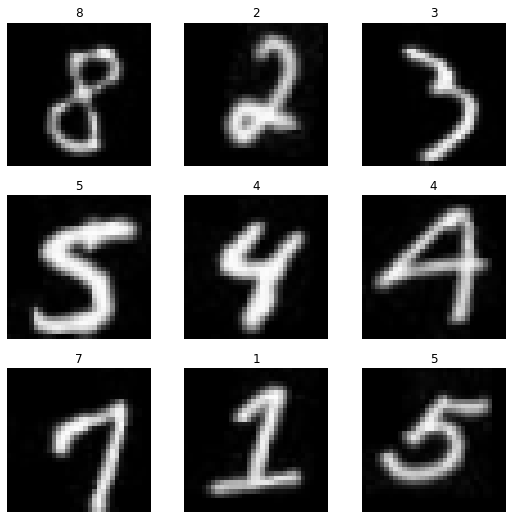

In [23]:
dls = ImageDataLoaders.from_folder(trn_path, valid_pct=0.2,
        batch_tfms=aug_transforms(size=32, min_scale=0.75, do_flip=False),
        bs=64)
dls.show_batch()

In [24]:
idxs = avg_pr.argmax(dim=1)
vocab = np.array(dls.vocab)
decoded = pd.Series(vocab[idxs], name="idxs")
decoded
#ss = pd.read_csv(path/'sample_submission.csv')
#ss.to_csv('subm-10.csv', index=False)

0        2
1        0
2        9
3        0
4        3
        ..
27995    9
27996    7
27997    3
27998    9
27999    2
Name: idxs, Length: 28000, dtype: object

Looks good so far!

## Prepare submission file

In [25]:
submission = pd.read_csv(path/'sample_submission.csv')

In [26]:
submission.shape

(28000, 2)

In [27]:
submission.Label = decoded
submission

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


## Submit CSV to Kaggle

In [28]:
# write submission csv
technique = 'ensamble finetune 5 epochs with TTA'
sub_filename = Path('subs')/(COMPETITION_NAME+'-'+technique+'-sub.csv')
submission.to_csv(sub_filename, index=False)

if not iskaggle:
    #for sec in tqdm(range(9000)):
    #    time.sleep(1)
    print('about to submit', sub_filename, 'to kaggle')
    ret = kaggle.api.competition_submit(sub_filename, technique, COMPETITION_NAME)
    print(ret)

about to submit subs/digit-recognizer-ensamble finetune 5 epochs with TTA-sub.csv to kaggle


100%|██████████| 208k/208k [00:00<00:00, 514kB/s]


Successfully submitted to Digit Recognizer


## (optional) Save the best model so far

In [96]:
print(COMPETITION_NAME)

digit-recognizer


In [103]:
# learn.export(fname='../../../models/'+(COMPETITION_NAME+'-'+technique)+'.pkl')